# <span style="color:#9400D3"> Prediction of higgs_pz using deep learning neural networks</span>
### Codes, Graphs and Results

## <span style="color:#b20000"> Required packages</span>

In [2]:
print(require(ggplot2))
print(require(scales))
print(require(gridExtra))
print(require(reshape2))
print(require(dplyr))
print(require(GGally))
print(require(h2o))
print(require(formattable))

[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE


## <span style="color:#b20000"> Data fetching and preprocessing</span>

In [4]:
setwd("/home/satyakama/Documents/manimala/final/final_programs")

dataset_1 <- data.table::fread("data11.dat",
                               sep = "auto",
                               dec = ".",
                               header = F,
                               strip.white = T,
                               blank.lines.skip = T)

dataset_2 <- data.table::fread("data22.dat",
                               sep = "auto",
                               dec = ".",
                               header = F,
                               strip.white = T,
                               blank.lines.skip = T)

master_data <- rbind(dataset_1,
                     dataset_2)

master_data <- master_data[, 1:25]

colnames(master_data) <- c("lp_px",
                           "lp_py",
                           "lp_pz",
                           "lp_e",
                           "lp_pt",
                           "lp_eta",
                           "lp_phi",
                           "lm_px",
                           "lm_py",
                           "lm_pz",
                           "lm_e",
                           "lm_pt",
                           "lm_eta",
                           "lm_phi",
                           "miss_px",
                           "miss_py",
                           "miss_pt",
                           "miss_phi",
                           "d_eta_lplm",
                           "d_phi_lplm",
                           "d_r_lplm",
                           "d_phi_lpmiss",
                           "d_phi_lmmiss",
                           "M",
                           "higgs_pz")

master_data <- data.frame(master_data)

#Removing duplicate rows if any
master_data <- master_data[!duplicated(master_data), ]

cat("The number of rows and columns in the master_data are",
    dim(master_data)[1],
    "and",
    dim(master_data)[2],
    "respectively.")


The number of rows and columns in the master_data are 100000 and 25 respectively.

## <span style="color:#b20000"> Exploratory Data Analysis - Graphs</span>

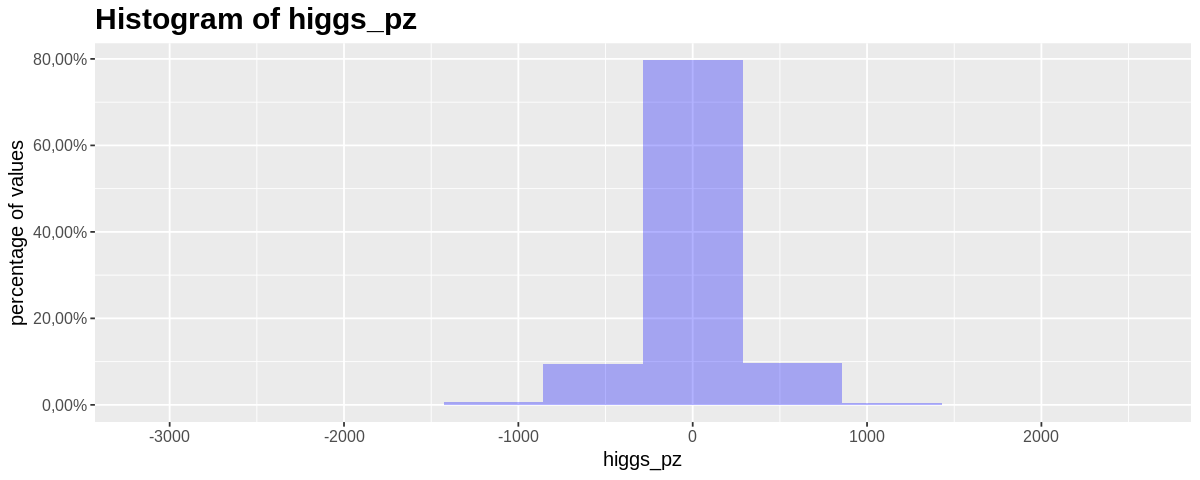

In [5]:
#Histogram of target feature
plot_0_hist_higgs_pz <- ggplot(master_data, aes(higgs_pz), fill = higgs_pz) + 
                          geom_histogram(aes(y = (..count..)/sum(..count..)), 
                                         bins = 10,
                                         fill = "blue",
                                         alpha = 0.3) + 
                          scale_y_continuous(labels=percent)+
                          labs(x = "higgs_pz",
                               y = "percentage of values",
                               title = "Histogram of higgs_pz")+
                          theme(plot.title = element_text(size = 18,
                                                          face = "bold"),
                                text = element_text(size=12),
                                legend.position = "none")

options(repr.plot.width=10, repr.plot.height=4)

plot_0_hist_higgs_pz


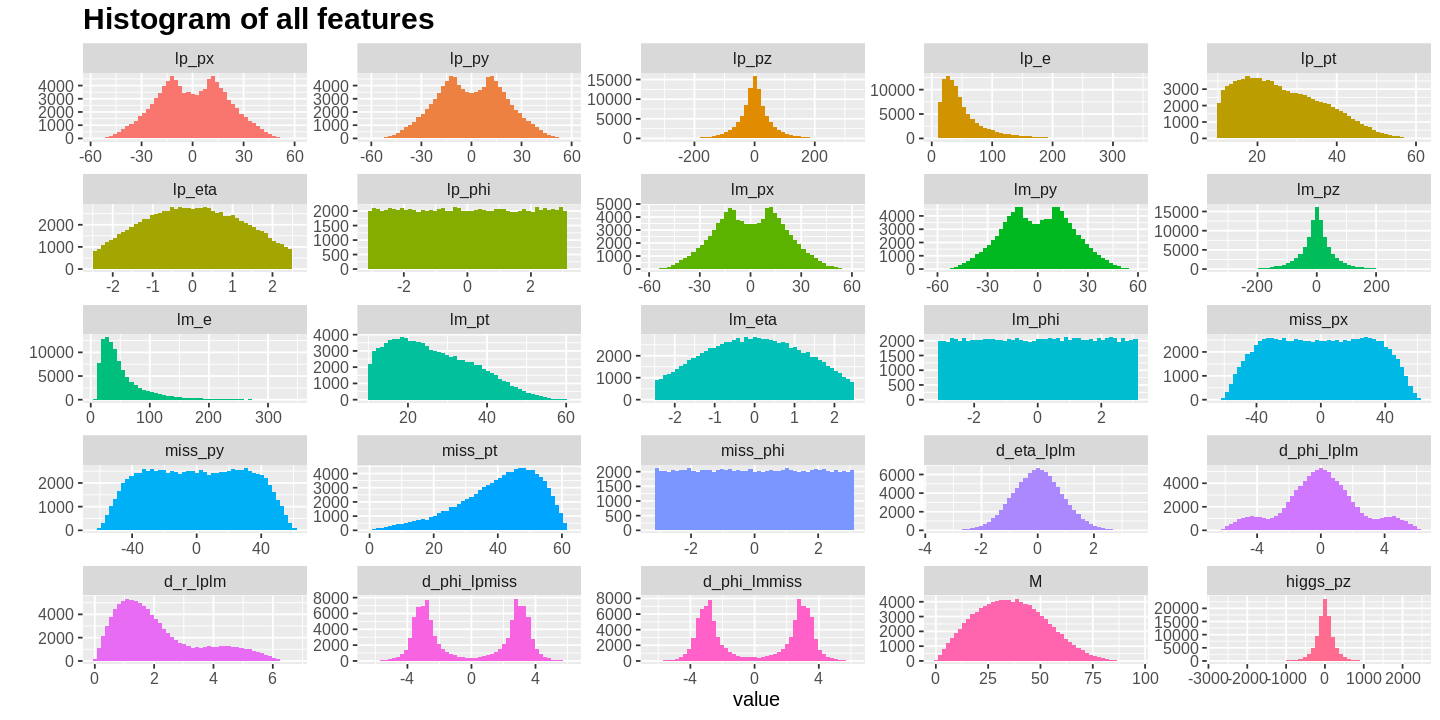

In [6]:
#Histogram of all features
master_data_id <- mutate(master_data,
                         id=as.numeric(rownames(master_data)))

master_data_stack <- melt(master_data_id,
                          id="id")

plot_1_hist <- qplot(value,
                     data = master_data_stack,
                     fill = variable,
                     bins=50) +
  facet_wrap(~variable,
             scales="free")+
  ggtitle("Histogram of all features")+
  theme(plot.title = element_text(size = 18,
                                  face = "bold"),
        text = element_text(size=12),
        legend.position = "none")

options(repr.plot.width=12, repr.plot.height=6)
plot_1_hist

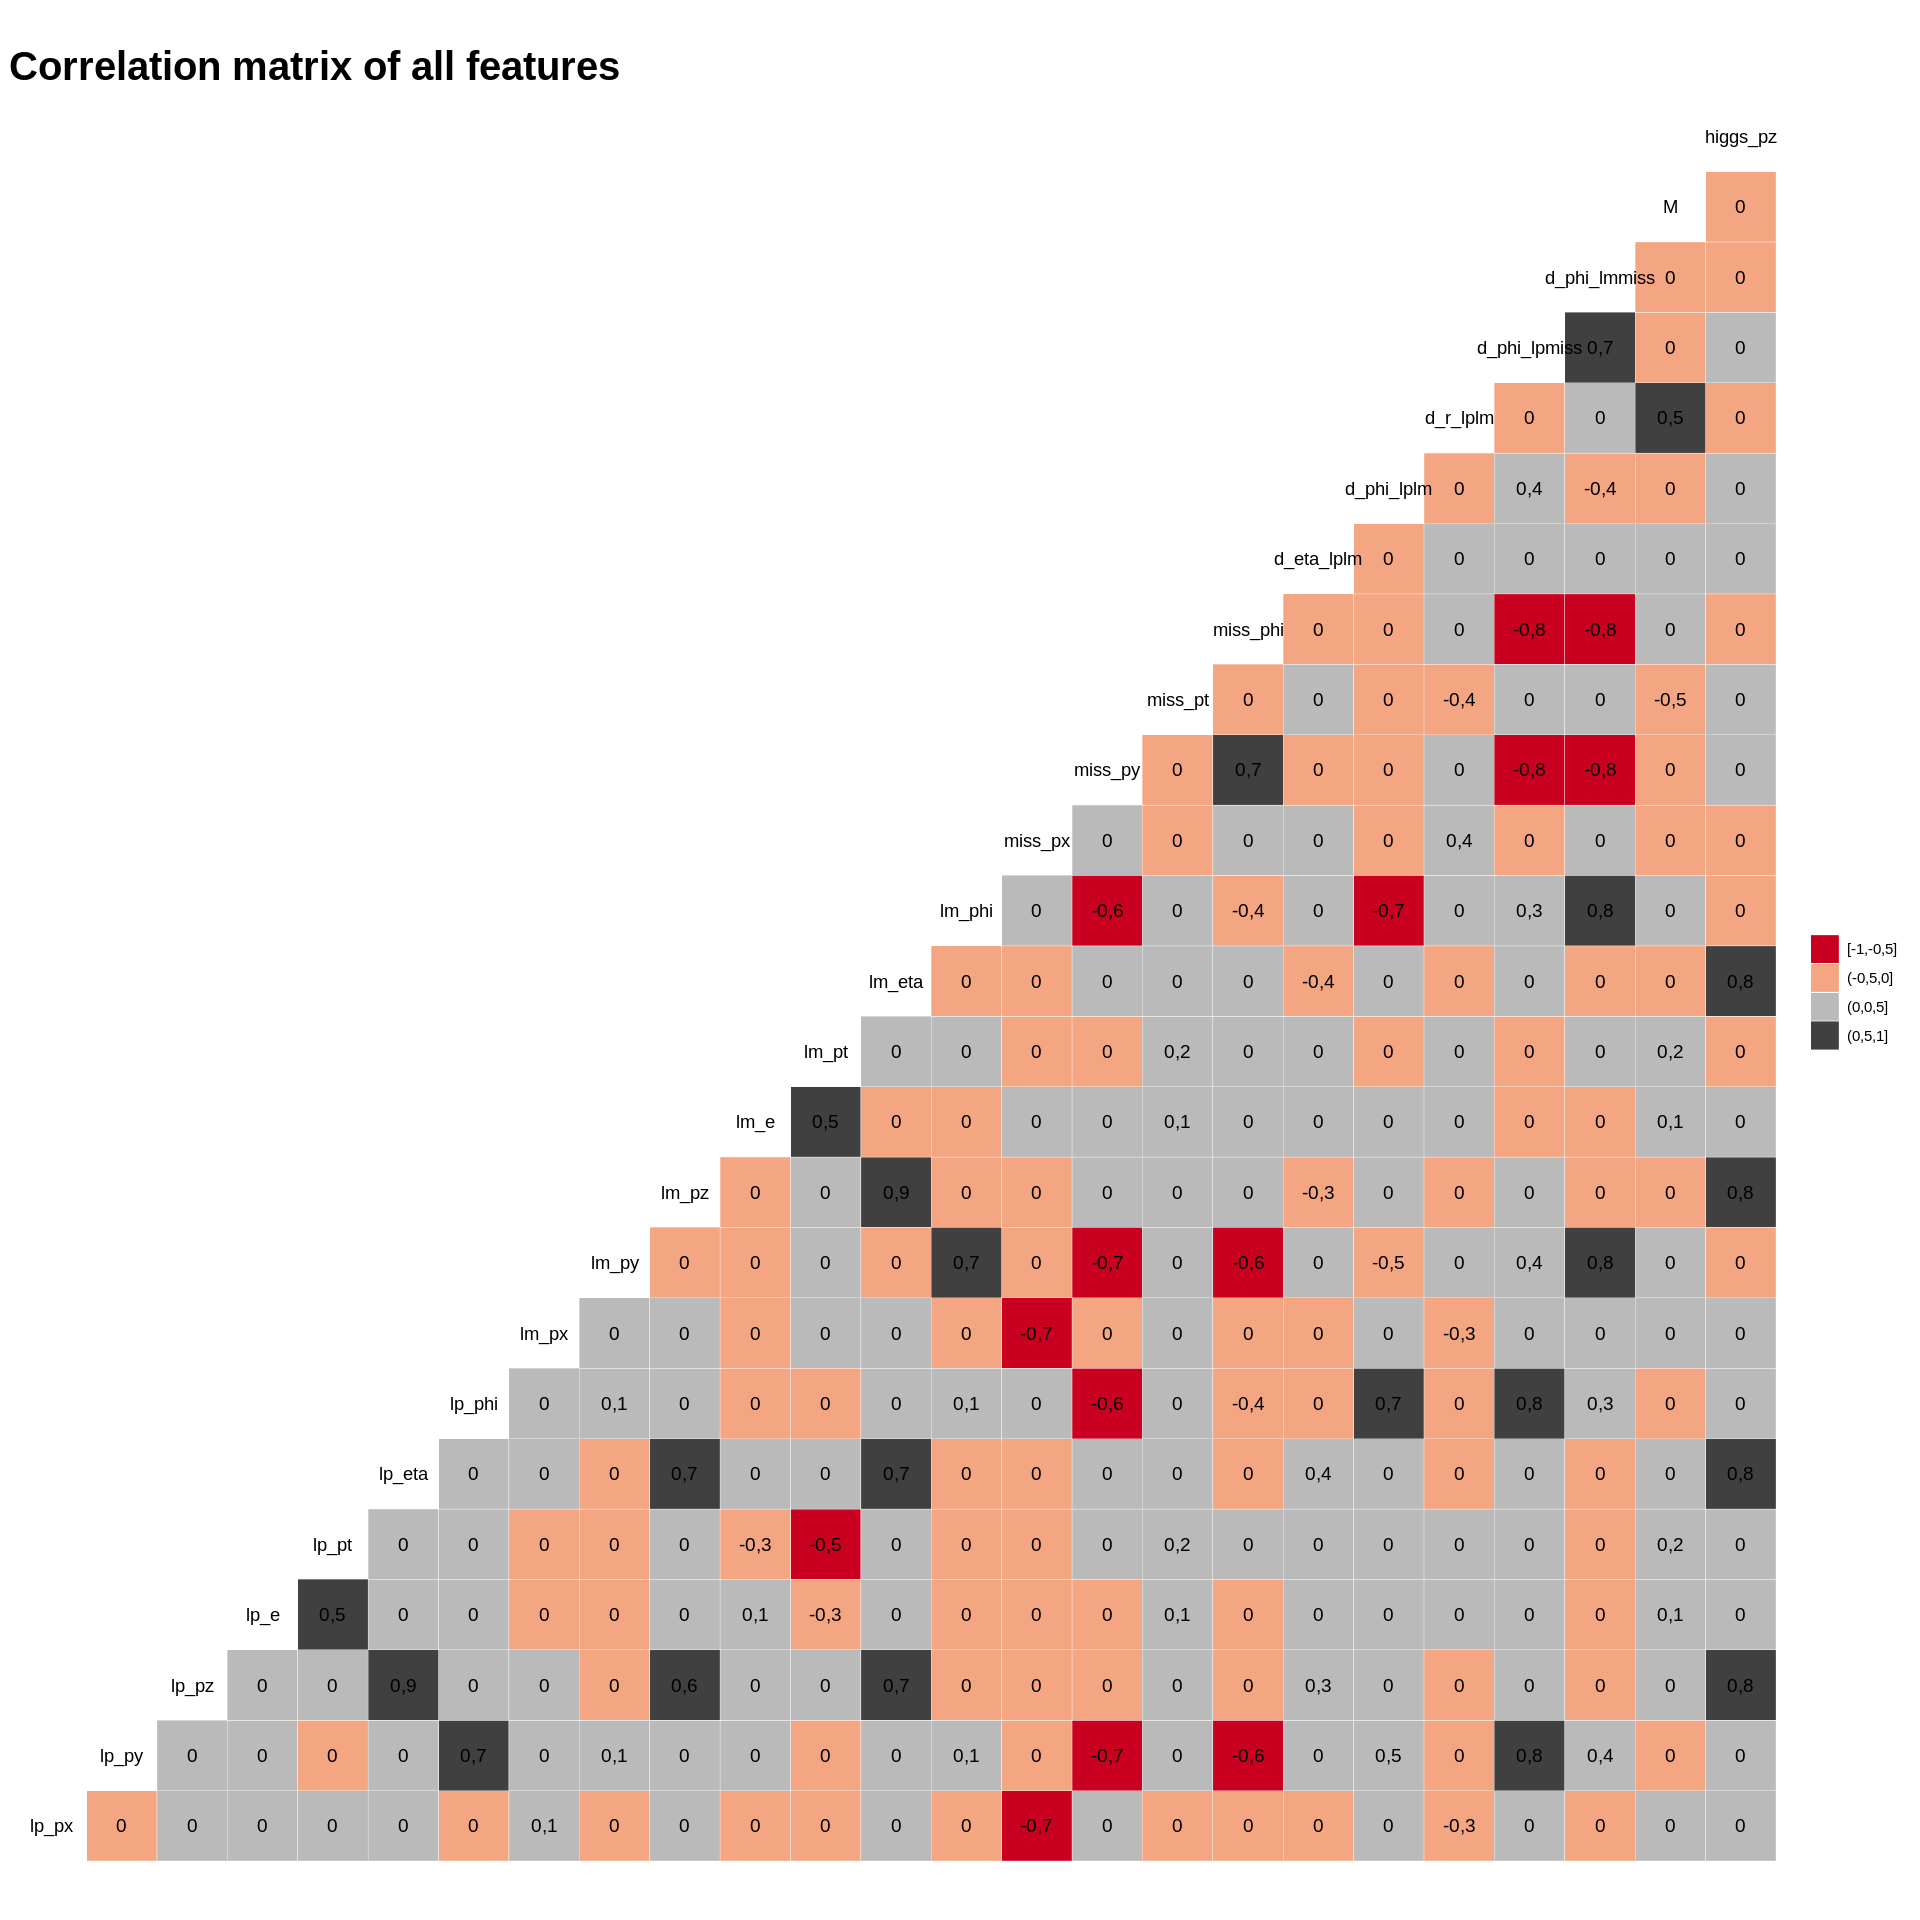

In [7]:
#Correlation plot
plot_2_corr_plot <- ggcorr(master_data,
                           nbreaks = 4,
                           palette = "RdGy",
                           label = TRUE) +
  ggtitle("Correlation matrix of all features") +
  theme(plot.title = element_text(size = 24,
                                  face = "bold"),
        text = element_text(size=5))

options(repr.plot.width=16, repr.plot.height=16)
plot_2_corr_plot


## <span style="color:#b20000">Splitting the master_data into training, validation and testing</span>


In [8]:
set.seed(100)

splitSample <- sample(1:3,
                      size=nrow(master_data),
                      prob=c(0.7,0.15,0.15),
                      replace = T)

training_data <- master_data[splitSample==1,]

cat("The number of rows and columns in training_data are", 
    dim(training_data)[1],
    "and",
    dim(training_data)[2],
    "respectively.",
   "\n")

validation_data <- master_data[splitSample==2,]

cat("The number of rows and columns in validation_data are", 
    dim(validation_data)[1],
    "and",
    dim(validation_data)[2],
    "respectively.",
   "\n")

testing_data <- master_data[splitSample==3,]

cat("The number of rows and columns in testing_data are", 
    dim(testing_data)[1],
    "and",
    dim(testing_data)[2],
    "respectively.",
   "\n")

The number of rows and columns in training_data are 70189 and 25 respectively. 
The number of rows and columns in validation_data are 15063 and 25 respectively. 
The number of rows and columns in testing_data are 14748 and 25 respectively. 


In [9]:
## Normalizing training, validation and testing datasets
training_data_n <- apply(training_data,
                         MARGIN = 2, 
                         FUN = function(X) (X - min(X))/diff(range(X)))

training_data_n <- data.frame(training_data_n)
                        
training_data_min <- apply(training_data,2,min)

training_data_max <- apply(training_data,2,max)                
                         

In [10]:
#Normalizing each column of validation data to [0,1] using the corresponding training col min and max

conversion_formula <- function(x,y,z){formula_str <- ((x-y)/(z-y))
                                        return(formula_str)}

validation_data_n = NULL

for(i in 1:ncol(validation_data)){
  
  validation_data_n[[i]] = conversion_formula(validation_data[,i], 
                                              training_data_min[i], 
                                              training_data_max[i])
  
validation_data_n <- data.frame(validation_data_n)}

colnames(validation_data_n) <- colnames(validation_data)

In [11]:
#Normalizing each column of testing data to [0,1] using the corresponding training col min and max
testing_data_n = NULL

for(i in 1:ncol(testing_data)){
  
  testing_data_n[[i]] = conversion_formula(testing_data[,i], 
                                           training_data_min[i], 
                                           training_data_max[i])
  
testing_data_n <- data.frame(testing_data_n)}

colnames(testing_data_n) <- colnames(testing_data)

## <span style="color:#b20000">Setting up h2o framework</span>

In [13]:
## H2O setup and AutoML

h2o.init(nthreads = -1,
                     min_mem_size = "10g",
                     max_mem_size = "12g")


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpGJAhfC/h2o_satyakama_started_from_r.out
    /tmp/RtmpGJAhfC/h2o_satyakama_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 366 milliseconds 
    H2O cluster timezone:       Asia/Kolkata 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.20.0.8 
    H2O cluster version age:    2 months and 3 days  
    H2O cluster name:           H2O_started_from_R_satyakama_lft083 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   10,67 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, A

## <span style="color:#b20000">Converting R objects to H2O objects</span>

In [14]:
options("h2o.use.data.table"=TRUE)

training_h2o_df <- as.h2o(training_data_n)

print("The dimensions in the training_h2o_df are")

h2o.dim(training_h2o_df)

validation_h2o_df <- as.h2o(validation_data_n)

print("The dimensions in the validation_h2o_df are")

h2o.dim(validation_h2o_df)

testing_h2o_df <- as.h2o(testing_data_n)

print("The dimensions in the testing_h2o_df are")

h2o.dim(testing_h2o_df)

target <- "higgs_pz"

print("Predictor")

formattable(as.data.frame(target))

predictors <- setdiff(names(training_h2o_df), 
                      target)

list_of_predictors <- as.data.frame(t(predictors))

print("List of predictors")

formattable(list_of_predictors)


  |======================================================================| 100%
[1] "The dimensions in the training_h2o_df are"


[1] 70189    25

  |======================================================================| 100%
[1] "The dimensions in the validation_h2o_df are"


[1] 15063    25

  |======================================================================| 100%
[1] "The dimensions in the testing_h2o_df are"


[1] 14748    25

[1] "Predictor"


target
higgs_pz


[1] "List of predictors"


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
lp_px,lp_py,lp_pz,lp_e,lp_pt,lp_eta,lp_phi,lm_px,lm_py,lm_pz,⋯,miss_px,miss_py,miss_pt,miss_phi,d_eta_lplm,d_phi_lplm,d_r_lplm,d_phi_lpmiss,d_phi_lmmiss,M


## <span style="color:#b20000">Modeling using AUTOML</span>

In [15]:
start.time <- print(Sys.time())

minutes <- 30

automl_h2o_models <- h2o.automl(x = predictors, 
                                y = target,
                                training_frame    = training_h2o_df,
                                leaderboard_frame = validation_h2o_df,
                                nfolds = 5, 
                                max_runtime_secs = 60*minutes,
                                max_models = 500,
                                stopping_metric = "RMSE",
                                exclude_algos = c("StackedEnsemble"),
                                seed = 123,
                                sort_metric = "RMSE")

end.time <- print(Sys.time())

beepr::beep(3)

[1] "2018-11-24 22:35:47 IST"
  |======================================================================| 100%
[1] "2018-11-24 23:06:14 IST"


In [16]:
automl_h2o_models

An object of class "H2OAutoML"
Slot "project_name":
[1] "automl_training_data_n"

Slot "leader":
Model Details:

H2ORegressionModel: gbm
Model ID:  GBM_grid_0_AutoML_20181124_223547_model_5 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              77                       77              117649         8
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         8    8,00000         44        177   116,00000


H2ORegressionMetrics: gbm
** Reported on training data. **

MSE:  6
RMSE:  0
MAE:  0
RMSLE:  0
Mean Residual Deviance :  6


H2ORegressionMetrics: gbm
** Reported on validation data. **

MSE:  6
RMSE:  0
MAE:  0
RMSLE:  0
Mean Residual Deviance :  6


H2ORegressionMetrics: gbm
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  7
RMSE:  0
MAE:  0
RMSLE:  0
Mean Residual Deviance :  7


Cross-Validation Metrics Summary: 
            

In [17]:
automl_h2o_all_models <- as.data.frame(automl_h2o_models@leaderboard)

automl_h2o_all_models

automl_best_model <- automl_h2o_models@leader

automl_best_model

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_0_AutoML_20181124_223547_model_5,7,0,7,0,0
GBM_grid_0_AutoML_20181124_223547_model_0,7,0,7,0,0
GBM_grid_0_AutoML_20181124_223547_model_1,7,0,7,0,0
GBM_grid_0_AutoML_20181124_223547_model_2,7,0,7,0,0
GBM_grid_0_AutoML_20181124_223547_model_4,7,0,7,0,0
DeepLearning_0_AutoML_20181124_223547,7,0,7,0,0
GBM_grid_0_AutoML_20181124_223547_model_6,7,0,7,0,0
GBM_grid_0_AutoML_20181124_223547_model_3,7,0,7,0,0
GLM_grid_0_AutoML_20181124_223547_model_0,7,0,7,0,0
DRF_0_AutoML_20181124_223547,7,0,7,0,0


Model Details:

H2ORegressionModel: gbm
Model ID:  GBM_grid_0_AutoML_20181124_223547_model_5 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              77                       77              117649         8
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         8    8,00000         44        177   116,00000


H2ORegressionMetrics: gbm
** Reported on training data. **

MSE:  6
RMSE:  0
MAE:  0
RMSLE:  0
Mean Residual Deviance :  6


H2ORegressionMetrics: gbm
** Reported on validation data. **

MSE:  6
RMSE:  0
MAE:  0
RMSLE:  0
Mean Residual Deviance :  6


H2ORegressionMetrics: gbm
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  7
RMSE:  0
MAE:  0
RMSLE:  0
Mean Residual Deviance :  7


Cross-Validation Metrics Summary: 
                               mean           sd   cv_1_valid  cv_2_valid
mae                      0.01845397

In [18]:
#Saving the Automl model for future reference
h2o.saveModel(automl_best_model, 
              path = "/home/satyakama/Documents/manimala/final/final_programs/to_send" )

[1] "/home/satyakama/Documents/manimala/final/final_programs/to_send/GBM_grid_0_AutoML_20181124_223547_model_5"

### <span style="color:blue">Best AUTOML model's prediction on testing_data</span>

In [19]:
#automl performance on test

perf_automl_test <- h2o.predict(automl_best_model, 
                                testing_h2o_df)

options("datatable.verbose"= FALSE)
options("h2o.use.data.table"=TRUE)

perf_automl_test <- as.data.frame(perf_automl_test)

colnames(perf_automl_test) <- c("predicted_y_n")

perf_automl_test$predicted_y_n <- as.numeric(perf_automl_test$predicted_y_n)

predicted_y <- (perf_automl_test$predicted_y_n*(max(training_data$higgs_pz) - min(training_data$higgs_pz)))+min(training_data$higgs_pz)

comp_df <- data.frame(cbind(testing_data$higgs_pz,
                            predicted_y))

colnames(comp_df) <- c("actual_y",
                       "predicted_y")

#Sorting the values of actual_y by ascending order

comp_df <- comp_df[order(comp_df$actual_y),]

serial_no <- seq(1, dim(comp_df)[1], 1)

comp_df <- cbind(comp_df, serial_no)

# write.table(comp_df,
#             file = "/home/satyakama/Documents/manimala/final/final_programs/to_send/comp_df_automl.csv",
#             row.names = F,
#             col.names = T,
#             dec = ".",
#             sep = ";")

  |======================================================================| 100%


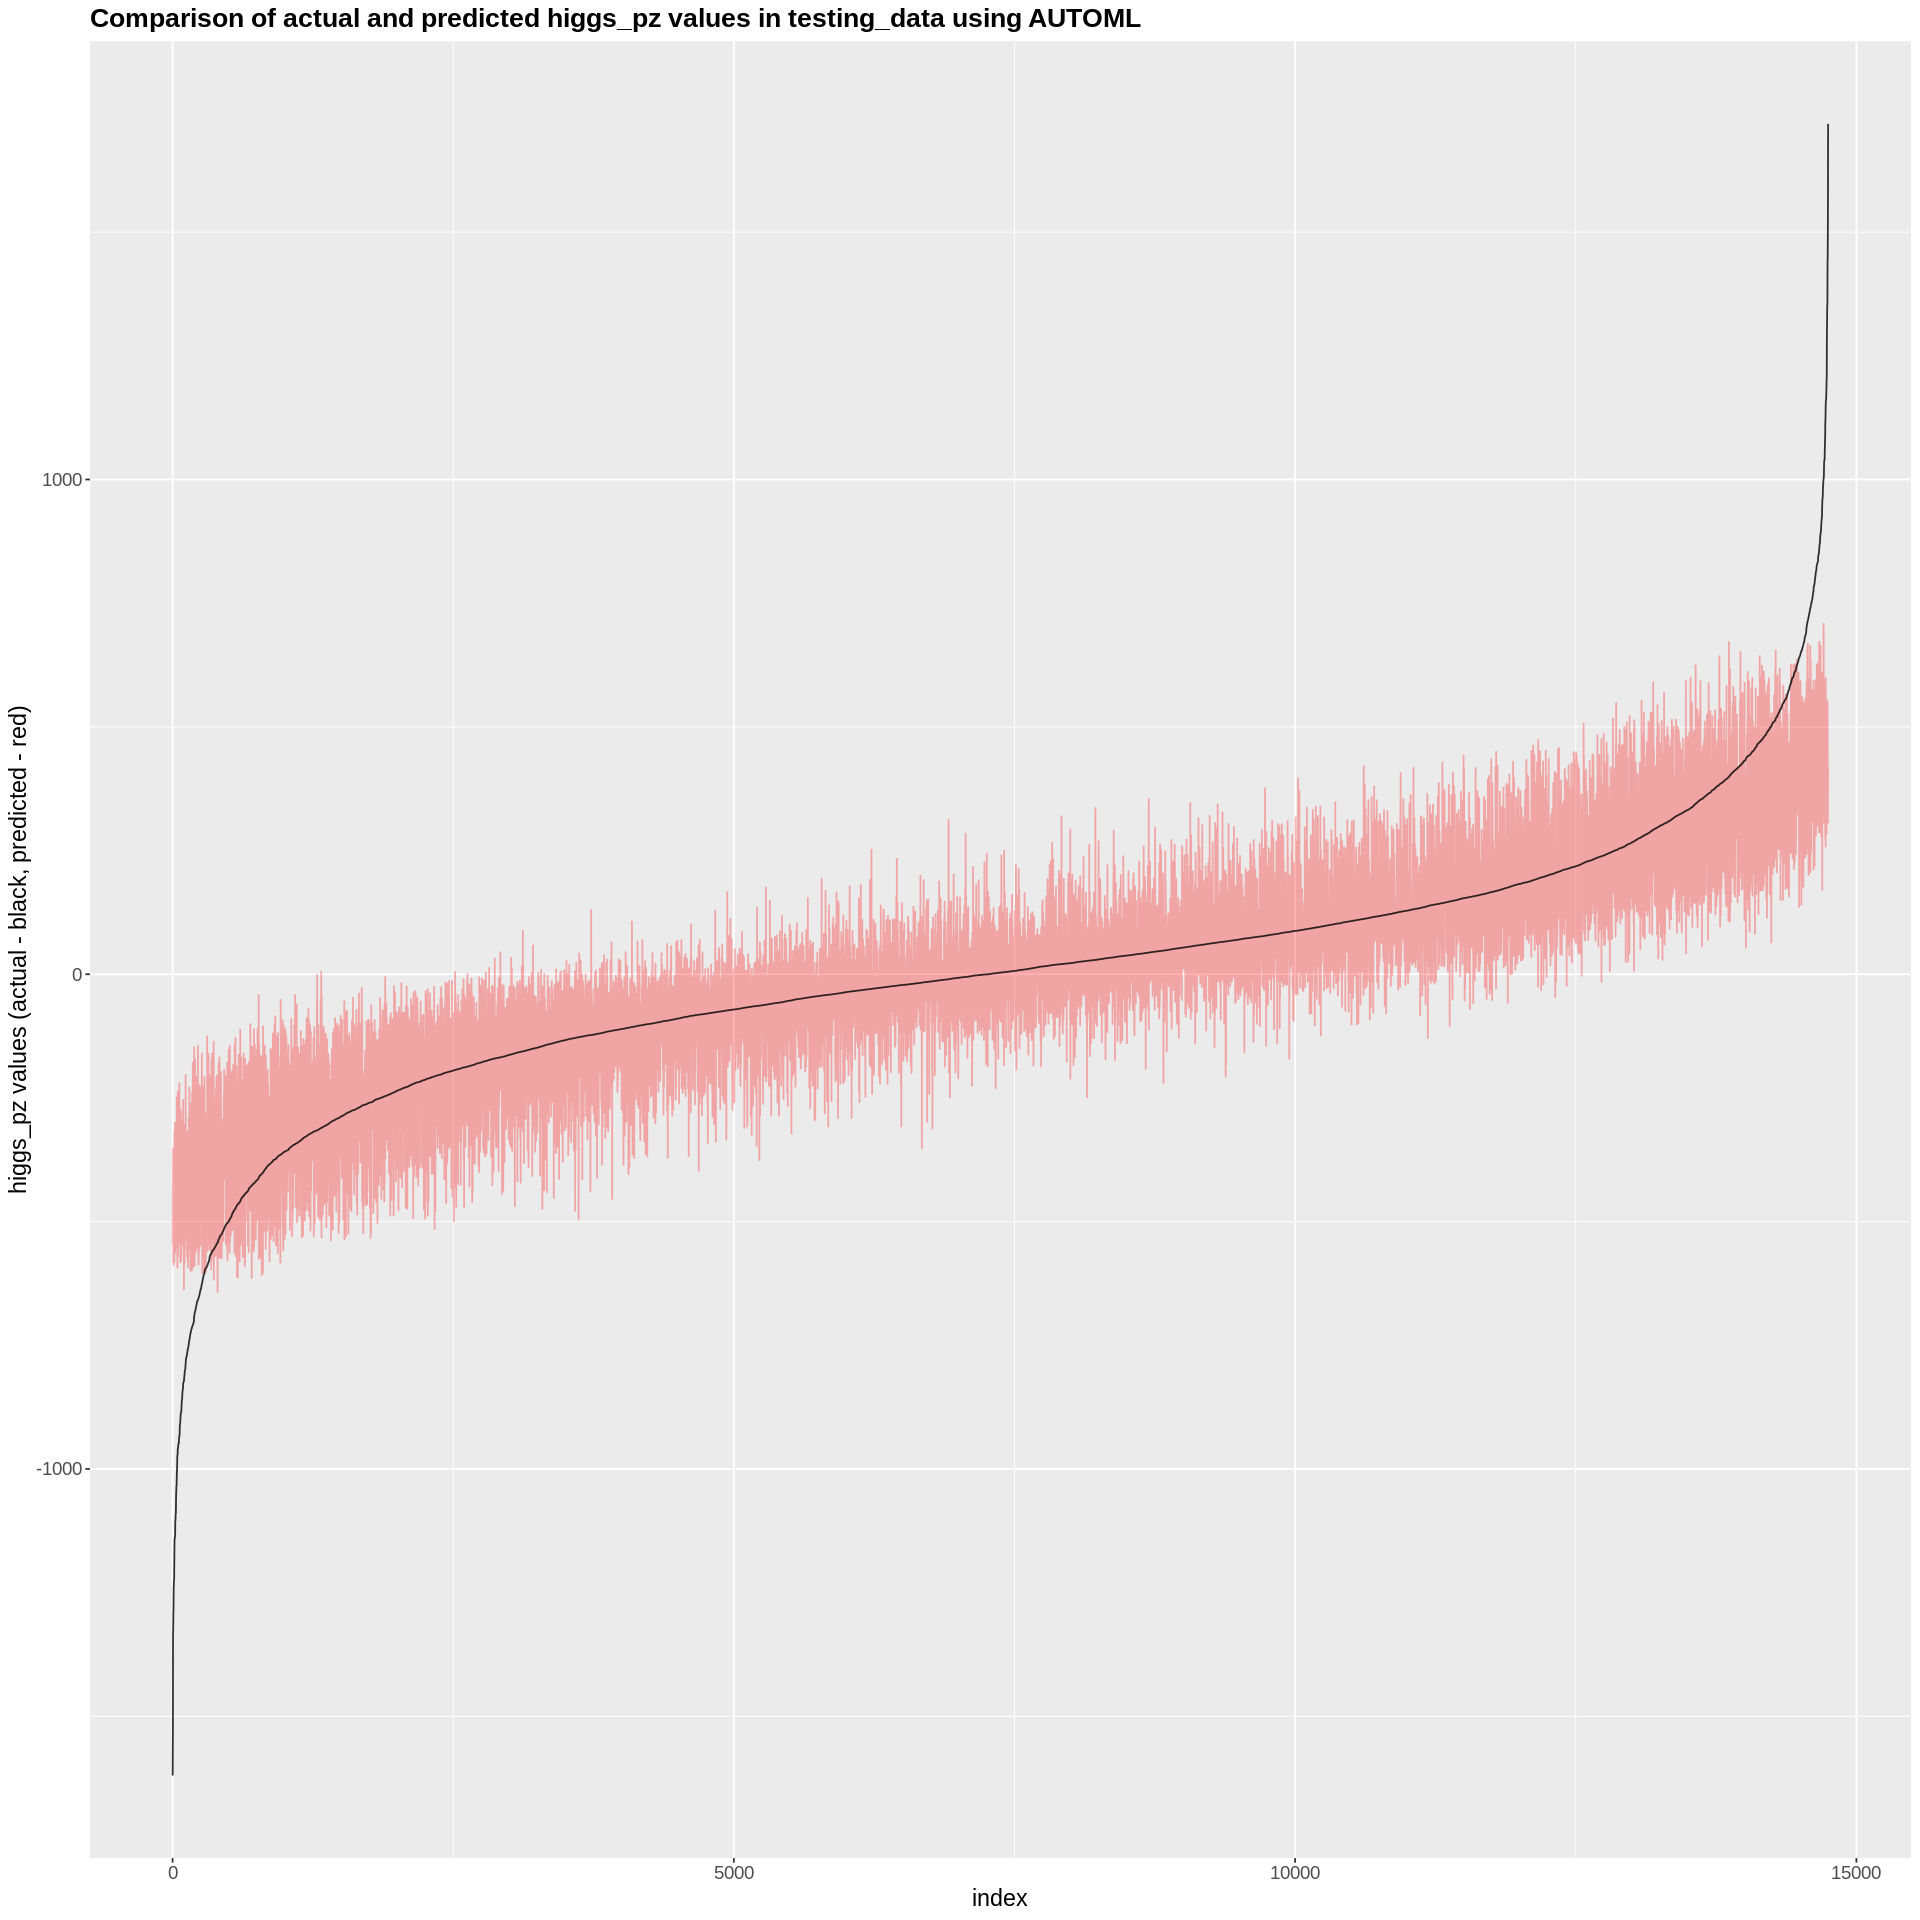

In [20]:
plot_3.1_pred_y <- ggplot(comp_df)+
                    geom_line(aes(y=predicted_y,x=serial_no),
                              col = "red",
                              alpha = 0.3)+
                    geom_line(aes(y=actual_y,x=serial_no),
                              alpha = 0.8)+
                      labs(x = "index",
                           y = "higgs_pz values (actual - black, predicted - red)",
                           title = "Comparison of actual and predicted higgs_pz values in testing_data using AUTOML")+
                    theme(plot.title = element_text(size = 16,
                                                    face = "bold"),
                            text = element_text(size=14),
                            legend.position = "none")

plot_3.1_pred_y                    

## <span style="color:#b20000">Hyper-parameter tuning of Deep Learning Neural Network</span>
+ Various combination of values of each of the hyper-parameters are chosen to find the optimal network with the lowest RMSE.

In [25]:
minutes = 60

hyper_params <- list(activation = c("Rectifier", 
                                    "Maxout", 
                                    "Tanh", 
                                    "RectifierWithDropout", 
                                    "MaxoutWithDropout", 
                                    "TanhWithDropout"),
                     hidden = list(c(190),
                                   c(200),
                                   c(210),
                                   c(15, 15, 15),
                                   c(20, 20, 20),
                                   c(24, 24, 24),
                                   c(100, 100, 100)),
                     epochs = c(50, 100, 150, 200),
                     l1 = c(0, 0.00001, 0.0001, 0.001, 0.01, 0.1), 
                     l2 = c(0, 0.00001, 0.0001, 0.001, 0.01, 0.1),
                     rate = c(0, 0.005, 0.001, 0.01),
                     rate_annealing = c(1e-8, 1e-7, 1e-6))

search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 100,
                        seed = 123,
                        stopping_metric = "RMSE",
                        max_runtime_secs = 60*minutes)

In [26]:
start.time <- print(Sys.time())

dl_grid <- h2o.grid(algorithm = "deeplearning", 
                    x = predictors, 
                    y = target,
                    training_frame = training_h2o_df,
                    validation_frame = validation_h2o_df,
                    grid_id = "dl_grid20",
                    nfolds = 5,                           
                    hyper_params = hyper_params,
                    search_criteria = search_criteria,
                    seed = 123)

end.time <- print(Sys.time())

[1] "2018-11-24 23:16:25 IST"
  |======================================================================| 100%
[1] "2018-11-25 00:16:37 IST"


In [28]:
dl_grid


H2O Grid Details

Grid ID: dl_grid20 
Used hyper parameters: 
  -  activation 
  -  epochs 
  -  hidden 
  -  l1 
  -  l2 
  -  rate 
  -  rate_annealing 
Number of models: 8 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing residual_deviance
         activation             epochs          hidden     l1     l2 rate
1   TanhWithDropout 15.917540443865485           [210]    0.0 1.0E-5  1.0
2 MaxoutWithDropout  32.78015773383694    [24, 24, 24]    0.0 1.0E-5  1.0
3 MaxoutWithDropout 12.166177020925673           [210] 1.0E-5    1.0  5.0
4 MaxoutWithDropout  54.42871178658108    [20, 20, 20]    0.0    1.0  0.0
5              Tanh 4.3521551250772195 [100, 100, 100]    0.0    1.0  1.0
6            Maxout 11.445154819182283           [190]    1.0    0.0  0.0
7            Maxout 28.680957136929788    [24, 24, 24]    1.0    0.0  0.0
8         Rectifier  4.273915266145543           [210]    1.0    0.0  0.0
  rate_annealing         model_ids     residual_deviance


In [30]:
dl_grid

dnn_gridperformance <- h2o.getGrid(grid_id = "dl_grid20", 
                                   sort_by = "RMSE", 
                                   decreasing = F)

dnn_gridperformance

best_dnn_model_id <- dnn_gridperformance@model_ids[[1]]

best_dnn <- h2o.getModel(best_dnn_model_id)

best_dnn

H2O Grid Details

Grid ID: dl_grid20 
Used hyper parameters: 
  -  activation 
  -  epochs 
  -  hidden 
  -  l1 
  -  l2 
  -  rate 
  -  rate_annealing 
Number of models: 8 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing residual_deviance
         activation             epochs          hidden     l1     l2 rate
1   TanhWithDropout 15.917540443865485           [210]    0.0 1.0E-5  1.0
2 MaxoutWithDropout  32.78015773383694    [24, 24, 24]    0.0 1.0E-5  1.0
3 MaxoutWithDropout 12.166177020925673           [210] 1.0E-5    1.0  5.0
4 MaxoutWithDropout  54.42871178658108    [20, 20, 20]    0.0    1.0  0.0
5              Tanh 4.3521551250772195 [100, 100, 100]    0.0    1.0  1.0
6            Maxout 11.445154819182283           [190]    1.0    0.0  0.0
7            Maxout 28.680957136929788    [24, 24, 24]    1.0    0.0  0.0
8         Rectifier  4.273915266145543           [210]    1.0    0.0  0.0
  rate_annealing         model_ids     residual_deviance


H2O Grid Details

Grid ID: dl_grid20 
Used hyper parameters: 
  -  activation 
  -  epochs 
  -  hidden 
  -  l1 
  -  l2 
  -  rate 
  -  rate_annealing 
Number of models: 8 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing RMSE
         activation             epochs          hidden     l1     l2 rate
1   TanhWithDropout 15.917540443865485           [210]    0.0 1.0E-5  1.0
2 MaxoutWithDropout  32.78015773383694    [24, 24, 24]    0.0 1.0E-5  1.0
3 MaxoutWithDropout 12.166177020925673           [210] 1.0E-5    1.0  5.0
4 MaxoutWithDropout  54.42871178658108    [20, 20, 20]    0.0    1.0  0.0
5              Tanh 4.3521551250772195 [100, 100, 100]    0.0    1.0  1.0
6            Maxout 11.445154819182283           [190]    1.0    0.0  0.0
7            Maxout 28.680957136929788    [24, 24, 24]    1.0    0.0  0.0
8         Rectifier  4.273915266145543           [210]    1.0    0.0  0.0
  rate_annealing         model_ids                 rmse
1         1.0E

Model Details:

H2ORegressionModel: deeplearning
Model ID:  dl_grid20_model_5 
Status of Neuron Layers: predicting higgs_pz, regression, gaussian distribution, Quadratic loss, 5,461 weights/biases, 72.8 KB, 1,158,830 training samples, mini-batch size 1
  layer units        type dropout       l1       l2 mean_rate rate_rms momentum
1     1    24       Input  0,00 %       NA       NA        NA       NA       NA
2     2   210 TanhDropout 50,00 % 0,000000 1,000000  0,000000 0,000000 0,000000
3     3     1      Linear      NA 0,000000 1,000000  4,000000 1,000000 0,000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2    0,000000   1,000000  0,000000 0,000000
3    0,000000   0,000000  7,000000 1,000000


H2ORegressionMetrics: deeplearning
** Reported on training data. **
** Metrics reported on temporary training frame with 9896 samples **

MSE:  7
RMSE:  0
MAE:  0
RMSLE:  0
Mean Residual Deviance :  7


H2ORegressionMetrics: deeplearning
** Reported

### <span style="color:blue">Best DNN model's prediction on testing_data</span>

In [31]:
best_dnn_prediction <- h2o.predict(best_dnn,
                                   testing_h2o_df)

best_dnn_prediction <- as.data.frame(best_dnn_prediction)

best_dnn_prediction$predict <- as.numeric(best_dnn_prediction$predict)

colnames(best_dnn_prediction) <- c("predicted_y_n")

best_dnn_prediction$predicted_y <- (best_dnn_prediction$predicted_y_n*(max(training_data$higgs_pz) - min(training_data$higgs_pz)))+min(training_data$higgs_pz)

comp_df_dnn <- data.frame(cbind(best_dnn_prediction$predicted_y,
                                testing_data$higgs_pz))

colnames(comp_df_dnn) <- c("predicted_y",
                           "actual_y")

comp_df_dnn <- comp_df_dnn[order(predicted_y),]

comp_df_dnn <- cbind(comp_df_dnn,
                     seq(1, length(testing_data$higgs_pz),1))

colnames(comp_df_dnn)[3] <- c("serial_no")


  |======================================================================| 100%


In [38]:
head(comp_df_dnn, 10)

,predicted_y,actual_y,serial_no
4887,"-436,5864","-542,780",1
14489,"-436,3144","-822,125",2
14065,"-436,0736","-555,634",3
1374,"-436,2490","-427,269",4
6966,"-436,3282","-465,132",5
10461,"-436,3349","-466,801",6
5339,"-436,0599","-466,480",7
12362,"-436,3398","-403,701",8
9439,"-435,6156","-622,351",9
1271,"-436,3016","-401,024",10


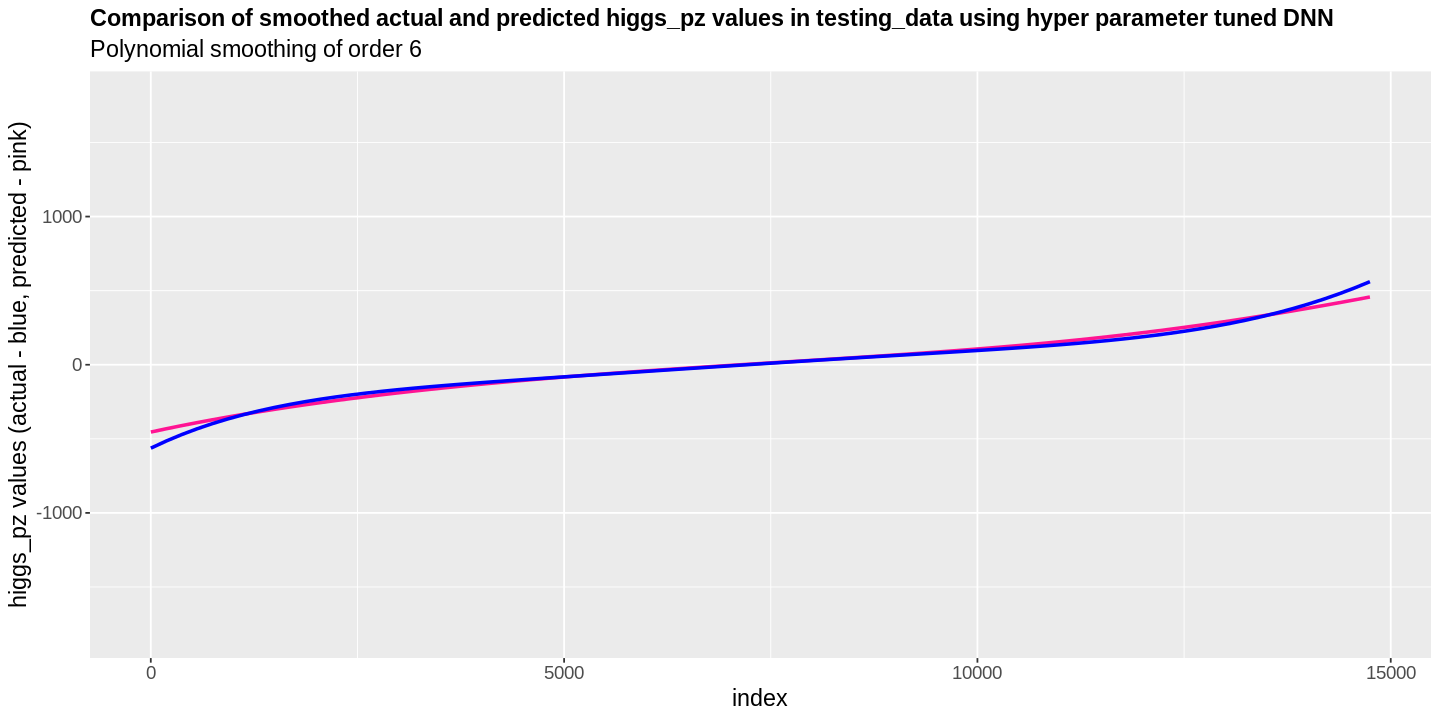

In [32]:
plot_4_pred_y <- ggplot(comp_df_dnn) + 
                      stat_smooth(aes(y=predicted_y, 
                                      x=serial_no), 
                                  method = lm, 
                                  formula = y ~ poly(x, 6), 
                                  colour = "deeppink",
                                  se = FALSE)+
                      stat_smooth(aes(y=actual_y,
                                      x=serial_no), 
                                  method = lm, 
                                  formula = y ~ poly(x, 6),
                                  colour = "blue",
                                  se = FALSE)+
                      scale_y_continuous(limits = c(-1800, 1800))+
                      labs(x = "index",
                           y = "higgs_pz values (actual - blue, predicted - pink)",
                           title = "Comparison of smoothed actual and predicted higgs_pz values in testing_data using hyper parameter tuned DNN",
                           subtitle = "Polynomial smoothing of order 6")+
                      theme(plot.title = element_text(size = 14,
                                                      face = "bold"),
                            text = element_text(size=14),
                            legend.position = "none")
options(repr.plot.width=12, repr.plot.height=6)

grid.arrange(plot_4_pred_y,
             nrow = 1, ncol = 1)

## Attached spreadsheets for comparison of predicted and actual test values
+ final_prediction.csv is attached in the email


In [39]:
write.table(comp_df_dnn,
            file = "/home/satyakama/Documents/manimala/final/final_programs/to_send/final_prediction.csv",
            sep = ";",
            row.names = F,
            col.names = T)

